# To do
1. Do Train validation test splits, use hyperparameter tuning on the train
3. run and report the result
Fix the AUPRC estimation (done)
implement nested CV for CV and hyperparameter tuning (done)
# Questions

In [68]:
import pandas as pd
import pickle
import numpy as np
import time
import os
import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

from skopt import BayesSearchCV
import skopt.space


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import xgboost


from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer,roc_curve, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn import svm

import scipy.stats

import umap


import seaborn as sns
import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow import keras
#from tensorboard.plugins import projector
#import kerastuner as kt



from tqdm import tqdm, tqdm_notebook
#import IPython
#%matplotlib widget

In [69]:
def load_obj(name ):
    with open('obj_' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [70]:
# Pandas settings
pd.set_option("display.max_rows", 100) 
pd.set_option("display.max_columns", 100) 
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.latex.longtable', True)
pd.DataFrame._repr_latex_ = lambda self: r"\begin{footnotesize}\centering{%s}\end{footnotesize}" % self.to_latex()

# 1. Import and combine data

In [71]:
filenames_input=['Anthropometrics and cardiac risk factors.csv',
                 'Baseline Medical Conditions.csv',
                 'Early life factors.csv',
                 'Home locations.csv',
                 'Pollutants.csv',
                 'sociodem_socioeco.csv',
                 'summary_diagnoses.csv']
path=r'/home/mo/Env_vars_DL/tidy_data_tiles/'

In [72]:
selected_categories_exclusions=load_obj('selected_categories_exclusions')
selected_categories_tidy_columns=load_obj('selected_categories_tidy_columns')
selected_categories_tidy=load_obj('selected_categories_tidy')

selected_outcome_categories_exclusions=load_obj('selected_outcome_categories_exclusions')
selected_outcome_categories_tidy_columns=load_obj('selected_outcome_categories_tidy_columns')
selected_outcome_categories_tidy=load_obj('selected_outcome_categories_tidy')

In [73]:
filenames_input

['Anthropometrics and cardiac risk factors.csv',
 'Baseline Medical Conditions.csv',
 'Early life factors.csv',
 'Home locations.csv',
 'Pollutants.csv',
 'sociodem_socioeco.csv',
 'summary_diagnoses.csv']

In [23]:
df_input=pd.DataFrame()
for filename in filenames_input:
    print(filename)
    if filename=='summary_diagnoses.csv':
        df_temp=pd.read_csv(path+filename,index_col='Unnamed: 0',nrows=1000)#nrows=20000
        df_temp.fillna(0,inplace=True)
        df_temp[df_temp!='1']=1
        df_temp[df_temp=='1']=0
    else:
        df_temp=pd.read_csv(path+filename,index_col='Unnamed: 0',nrows=1000)#,nrows=20000
    df_input=pd.concat([df_input,df_temp],axis=1)
del df_temp
df_label=pd.read_csv(path+'Outcomes.csv',index_col='Unnamed: 0',nrows=1000)#nrows=20000

Anthropometrics and cardiac risk factors.csv
Baseline Medical Conditions.csv
Early life factors.csv
Home locations.csv
Pollutants.csv
sociodem_socioeco.csv
summary_diagnoses.csv


/home/mo/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [142]:
df_temp=pd.read_csv(path+"summary_diagnoses.csv",index_col='Unnamed: 0',nrows=50000)
df_temp=df_temp.notnull().astype(int)

In [135]:
df_temp.sum().iloc[:50]

A04 Other bacterial intestinal infections                                                                           174
A08 Viral and other specified intestinal infections                                                                  22
A09.9 Gastroenteritis and colitis of unspecified origin                                                               0
A30-A49 Other bacterial diseases                                                                                    118
A41.9 Septicaemia, unspecified                                                                                       55
B00-B09 Viral infections characterized by skin and mucous membrane lesions                                          102
B34.9 Viral infection, unspecified                                                                                  122
C00-C14 Malignant neoplasms of lip, oral cavity and pharynx                                                          53
C15 Malignant neoplasm of oesophagus    

In [26]:
df_input.shape

(1000, 1105)

In [27]:
df_input.drop(columns=["20115-0.0","129-0.0","130-0.0"],inplace=True) #drop place of birth, long_lat birth.

In [28]:
selected_categories_tidy_columns["41270"]["type"]="binary"

In [29]:
df_input.shape

(1000, 1102)

## 1.1 column to variable dict

In [30]:
#rename_cols_names_dict={v['col_name'][0]:k for k,v in selected_categories_tidy_columns.items() if len(v['col_name'])==1}
#df_input.rename(columns=rename_cols_names_dict,inplace=True)

In [31]:
#for k,v in rename_cols_names_dict.items():
#    selected_categories_tidy_columns[v]['col_name']=[v]    

In [32]:
column_to_var_dict=dict()
for k,v in selected_categories_tidy_columns.items():
    for col in v['col_name']:
        column_to_var_dict[col]=[k,v['type']]
        
#column_to_var_dict

# 2. convert dtype and impute

In [33]:
#df_input.rename(columns={"129":'Place of birth in UK - north co-ordinate',"130":'Place of birth in UK - east co-ordinate',"20115": 'Country of Birth',"20022":'Birth weight'},
#                inplace=True)


#column_to_var_dict['Place of birth in UK - north co-ordinate']=['Place of birth in UK - north co-ordinate','int']
#column_to_var_dict['Place of birth in UK - east co-ordinate']=['Place of birth in UK - east co-ordinate','int']
#column_to_var_dict['Birth weight']=['Birth weight','float']
#column_to_var_dict['Country of Birth']=['Country of Birth','int']
column_to_var_dict['130-0.0']

['Place of birth in UK - east co-ordinate', 'int']

In [34]:
for variable in selected_categories_tidy_columns.keys():
    print('Converting column:'+variable+' to dtype *'+selected_categories_tidy_columns[variable]["type"])


Converting column:gender to dtype *binary
Converting column:birth_date to dtype *date
Converting column:Townsend deprivation index at recruitment to dtype *float
Converting column:Age at recruitment to dtype *int
Converting column:Ethnicity to dtype *binary
Converting column:Current employment status to dtype *binary
Converting column:Household Income to dtype *binary
Converting column:Qualifications to dtype *binary
Converting column:Standing height to dtype *int
Converting column:BMI to dtype *float
Converting column:SBP to dtype *int
Converting column:DBP to dtype *int
Converting column:PR to dtype *int
Converting column:Cholesterol_to_HDL_Cholesterol to dtype *binary
Converting column:Alcohol Status to dtype *binary
Converting column:Smoking Status to dtype *binary
Converting column:Baseline Medical conditions to dtype *binary
Converting column:Home location at assessment to dtype *int
Converting column:Home area population density to dtype *int
Converting column:24003: Nitrogen di

In [35]:
nan_per=df_input.isna().sum()
nan_per=nan_per[nan_per>0]
nan_per

50-0.0                              4
21001-0.0                           7
SBP_avg                            63
DBP_avg                            63
PR_avg                             63
Cholesterol_to_HDL_Cholesterol    141
20022-0.0                         437
Home_Longitude                     12
Home_Latitude                      12
20118-0.0                          12
24005-0.0                          84
24007-0.0                          84
24003-0.0                          15
24008-0.0                          84
24006-0.0                          84
24004-0.0                          15
24010-0.0                          15
24012-0.0                          15
24015-0.0                          15
24011-0.0                          15
24009-0.0                          15
24013-0.0                          15
189-0.0                             3
dtype: int64

In [36]:
df_input[nan_per.index.values].head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Cholesterol_to_HDL_Cholesterol,20022-0.0,Home_Longitude,Home_Latitude,20118-0.0,24005-0.0,24007-0.0,24003-0.0,24008-0.0,24006-0.0,24004-0.0,24010-0.0,24012-0.0,24015-0.0,24011-0.0,24009-0.0,24013-0.0,189-0.0
0,154.0,29.9798,136.0,75.0,82.0,3.769826,NaN,340000.0,388000.0,5.0,14.48,1.23,31.57,5.68,10.40,53.83,0.04,0.00226,0.0,15763.0,500.0,0.0,-0.953776
1,174.0,24.4088,124.0,78.0,66.0,3.425455,NaN,337000.0,388000.0,5.0,15.93,1.26,29.36,6.02,9.96,45.93,0.04,0.00549,0.0,14247.0,500.0,0.0,5.116970
2,166.0,29.3584,119.0,76.0,58.0,3.511751,NaN,524000.0,168000.0,5.0,16.84,1.30,29.68,6.42,9.27,46.93,0.03,0.00094,0.0,26109.0,500.0,0.0,-2.322980
3,179.0,30.6170,170.0,107.0,56.0,6.656085,3.29,512000.0,172000.0,5.0,19.17,1.58,33.70,7.79,11.60,60.85,0.06,0.00831,0.0,67683.0,500.0,0.0,-0.804055
4,168.0,31.3209,NaN,NaN,NaN,3.964724,NaN,379000.0,417000.0,5.0,14.90,0.97,25.46,5.87,10.85,45.61,0.04,0.00345,0.0,15765.0,500.0,0.0,-0.346170


In [37]:
column_to_var_dict["20022-0.0"]

['Birth weight', 'float']

In [38]:
[column_to_var_dict[var] for var in list(nan_per.index.values)]

[['Standing height', 'int'],
 ['BMI', 'float'],
 ['SBP', 'int'],
 ['DBP', 'int'],
 ['PR', 'int'],
 ['Cholesterol_to_HDL_Cholesterol', 'binary'],
 ['Birth weight', 'float'],
 ['Home location at assessment', 'int'],
 ['Home location at assessment', 'int'],
 ['Home area population density', 'int'],
 ['24005: Particulate matter air pollution (pm10); 2010', 'float'],
 ['24007: Particulate matter air pollution (pm2.5) absorbance; 2010', 'float'],
 ['24003: Nitrogen dioxide air pollution; 2010', 'float'],
 ['24008: Particulate matter air pollution 2.5-10um; 2010', 'float'],
 ['24006: Particulate matter air pollution (pm2.5); 2010', 'float'],
 ['24004: Nitrogen oxides air pollution; 2010', 'float'],
 ['24010: Inverse distance to the nearest road', 'float'],
 ['24012: Inverse distance to the nearest major road', 'float'],
 ['24015: Sum of road length of major roads within 100m', 'float'],
 ['24011: Traffic intensity on the nearest major road', 'int'],
 ['24009: Traffic intensity on the nearest 

In [39]:
df_input.isna().any(axis=1).sum()

581

In [40]:
df_input_impt=df_input.copy()
cols_with_na=df_input.loc[:,df_input.iloc[:,:].isna().sum()>0].columns.values

imp_strtgy={'int':'mean','float':'mean','binary':'constant'}
for col in cols_with_na:
    print(column_to_var_dict[col])
    imp = SimpleImputer(missing_values=np.nan,fill_value=0, strategy=imp_strtgy[column_to_var_dict[col][1]])
    X=df_input_impt[col].to_numpy().reshape(-1, 1)
    imp.fit(X)
    df_input_impt[col]=imp.transform(X)    

['Standing height', 'int']
['BMI', 'float']
['SBP', 'int']
['DBP', 'int']
['PR', 'int']
['Cholesterol_to_HDL_Cholesterol', 'binary']
['Birth weight', 'float']
['Home location at assessment', 'int']
['Home location at assessment', 'int']
['Home area population density', 'int']
['24005: Particulate matter air pollution (pm10); 2010', 'float']
['24007: Particulate matter air pollution (pm2.5) absorbance; 2010', 'float']
['24003: Nitrogen dioxide air pollution; 2010', 'float']
['24008: Particulate matter air pollution 2.5-10um; 2010', 'float']
['24006: Particulate matter air pollution (pm2.5); 2010', 'float']
['24004: Nitrogen oxides air pollution; 2010', 'float']
['24010: Inverse distance to the nearest road', 'float']
['24012: Inverse distance to the nearest major road', 'float']
['24015: Sum of road length of major roads within 100m', 'float']
['24011: Traffic intensity on the nearest major road', 'int']
['24009: Traffic intensity on the nearest road', 'int']
['24013: Total traffic load

# 2. Modelling

# 2. Preps

In [41]:
df_input_impt.loc[:,~df_input_impt.columns.isin(selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]+list(selected_categories_tidy_columns["41270"]["col_name"]))].head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Cholesterol_to_HDL_Cholesterol,Alcohol Status_Current,Alcohol Status_Never,Alcohol Status_Prefer not to answer,Alcohol Status_Previous,Smoking Status_Current,Smoking Status_Never,Smoking Status_Prefer not to answer,Smoking Status_Previous,myasthenia gravis.1,20022-0.0,Exclude_Home_location,Home_Longitude,Home_Latitude,20118-0.0,24005-0.0,24007-0.0,24003-0.0,24008-0.0,24006-0.0,24004-0.0,24010-0.0,24012-0.0,24015-0.0,24011-0.0,24009-0.0,24014-0.0,24013-0.0,21022-0.0,189-0.0,31-0.0,birth_date,Ethnicity_African,Ethnicity_Any other Asian background,Ethnicity_Any other Black background,Ethnicity_Any other mixed background,Ethnicity_Any other white background,Ethnicity_Asian or Asian British,Ethnicity_Bangladeshi,Ethnicity_Black or Black British,Ethnicity_British,Ethnicity_Caribbean,Ethnicity_Chinese,Ethnicity_Do not know,Ethnicity_Indian,Ethnicity_Irish,Ethnicity_Mixed,Ethnicity_Other ethnic group,Ethnicity_Pakistani,Ethnicity_Prefer not to answer,Ethnicity_White,Ethnicity_White and Asian,Ethnicity_White and Black African,Ethnicity_White and Black Caribbean,Employment_Doing unpaid or voluntary work,Employment_Full or part-time student,Employment_In paid employment or self-employed,Employment_Looking after home and/or family,Employment_None of the above,Employment_Prefer not to answer,Employment_Retired,Employment_Unable to work because of sickness or disability,Employment_Unemployed,"Household_inc_18,000 to 30,999","Household_inc_31,000 to 51,999","Household_inc_52,000 to 100,000",Household_inc_Do not know,"Household_inc_Greater than 100,000","Household_inc_Less than 18,000",Household_inc_Prefer not to answer,Qualifications_A levels/AS levels or equivalent,Qualifications_CSEs or equivalent,Qualifications_College or University degree,Qualifications_NVQ or HND or HNC or equivalent,Qualifications_None of the above,Qualifications_O levels/GCSEs or equivalent,"Qualifications_Other professional qualifications eg: nursing, teaching",Qualifications_Prefer not to answer
0,154.0,29.9798,136.000000,75.000000,82.000000,3.769826,1,0,0,0,0,0,0,1,0,3.367442,False,340000.0,388000.0,5.0,14.48,1.23,31.57,5.68,10.40,53.83,0.04,0.00226,0.0,15763.0,500.0,0,0.0,62,-0.953776,0,1947-02-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,174.0,24.4088,124.000000,78.000000,66.000000,3.425455,1,0,0,0,0,0,0,1,0,3.367442,False,337000.0,388000.0,5.0,15.93,1.26,29.36,6.02,9.96,45.93,0.04,0.00549,0.0,14247.0,500.0,0,0.0,56,5.116970,0,1952-12-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,166.0,29.3584,119.000000,76.000000,58.000000,3.511751,1,0,0,0,0,1,0,0,0,3.367442,True,524000.0,168000.0,5.0,16.84,1.30,29.68,6.42,9.27,46.93,0.03,0.00094,0.0,26109.0,500.0,0,0.0,49,-2.322980,0,1960-10-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,179.0,30.6170,170.000000,107.000000,56.000000,6.656085,1,0,0,0,0,1,0,0,0,3.290000,False,512000.0,172000.0,5.0,19.17,1.58,33.70,7.79,11.60,60.85,0.06,0.00831,0.0,67683.0,500.0,0,0.0,47,-0.804055,1,1962-05-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,168.0,31.3209,137.929562,82.437567,69.314835,3.964724,1,0,0,0,0,0,0,1,0,3.367442,False,379000.0,417000.0,5.0,14.90,0.97,25.46,5.87,10.85,45.61,0.04,0.00345,0.0,15765.0,500.0,0,0.0,67,-0.346170,1,1941-02-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [42]:
selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]=list(set(selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]))

In [43]:
for word in selected_categories_tidy_columns["Baseline Medical conditions"]["col_name"]:
    if "myasthenia" in word:
        print(word)

myasthenia gravis


In [44]:
df_input_impt.drop(columns="myasthenia gravis.1",inplace=True)
df_input_impt.drop(columns=['birth_date'],inplace=True)

In [45]:
df_label.head()

,outcome_months,Exclude_outcomes,outcomes,death,Exclude_statin_use
0,96.560504,0,0,NaN,0
1,98.564652,0,0,NaN,0
2,85.028440,0,0,NaN,0
3,91.960821,0,0,NaN,0
4,108.946796,0,0,NaN,1


In [46]:
df_input_impt.shape

(1000, 1100)

## Prep Outcomes

In [47]:
df_label["outcomes_1year"]=0

In [48]:
df_label.loc[(df_label["outcomes"]) & (df_label["outcome_months"]<=120),"outcomes_1year"]=1

In [49]:
neg, pos = np.bincount(df_label['outcomes_1year'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1000
    Positive: 78 (7.80% of total)



In [50]:
[col for col in df_input.columns if "Exclude" in col]

['Exclude_baseline_MedCon', 'Exclude_Home_location']

## 2.1 Exclusions

In [51]:
selected_categories_exclusions.remove('Exclude_Home_location')

In [53]:
selected_categories_exclusions

['Exclude_baseline_MedCon']

In [54]:
exclusion_indx=df_input_impt.index[pd.concat([df_input_impt[selected_categories_exclusions],
           df_label[selected_outcome_categories_exclusions]],axis=1).any(axis=1)]

df_input_impt.drop(index=exclusion_indx,inplace=True)
df_label.drop(index=exclusion_indx,inplace=True)

df_input_impt.drop(columns=selected_categories_exclusions+["Exclude_Home_location"],inplace=True)
df_label.drop(columns=selected_outcome_categories_exclusions,inplace=True)

In [55]:
selected_categories_tidy_columns['Baseline Medical conditions']['col_name'].remove("Exclude_baseline_MedCon")

## Age

In [56]:
#selected_categories_tidy_columns

In [57]:
dummies_df=pd.get_dummies(pd.qcut(df_input_impt["21022-0.0"],4))
dummies_df=dummies_df.reindex(index=df_input_impt.index)
col_names={intervalItem:"({val1:0.2f},{val2:0.2f}]".format(val1=intervalItem.left,val2=intervalItem.right) for intervalItem in dummies_df.columns.values.tolist()}
dummies_df.rename(columns=col_names,inplace=True)
col_num=3
print(dummies_df.columns[col_num])
indx_age=dummies_df[dummies_df[dummies_df.columns[col_num]]==1].index

(62.00,70.00]


# Normalise

In [58]:
non_binary_cols1=df_input_impt.columns[df_input_impt.nunique()>2].values

In [59]:
non_binary_cols=[k for k,v in column_to_var_dict.items() if v[1] !='binary']

In [60]:
set(non_binary_cols)-set(non_binary_cols1)

{'129-0.0', '130-0.0', '20115-0.0', 'birth_date'}

In [61]:
non_binary_cols=[k for k,v in column_to_var_dict.items() if v[1] !='binary']
non_binary_cols=list(set(non_binary_cols) & set(df_input_impt.columns.values))

In [62]:
scaler = StandardScaler()
df_input_stnd_temp=scaler.fit_transform(df_input_impt[non_binary_cols])
df_input_stnd_temp = np.clip(df_input_stnd_temp, -5, 5)
df_input_stnd=df_input_impt.copy()
df_input_stnd[non_binary_cols]=df_input_stnd_temp

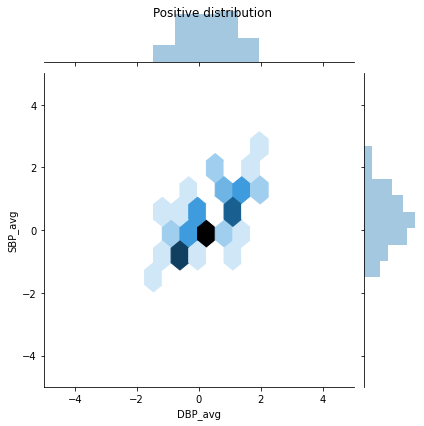

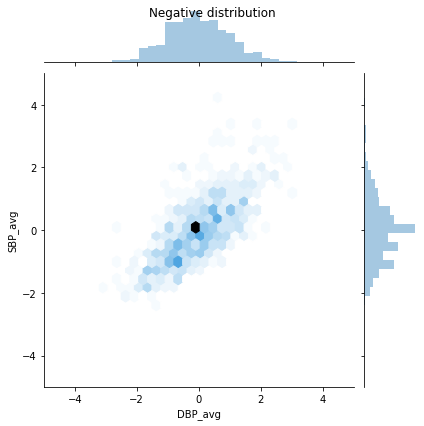

In [63]:
bool_train_labels=df_label["outcomes_1year"]!=0


pos_df = df_input_stnd.loc[df_label["outcomes_1year"]==1]
neg_df = df_input_stnd.loc[df_label["outcomes_1year"]==0]


var1='DBP_avg'
var2='SBP_avg'
sns.jointplot(pos_df[var1], pos_df[var2],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df[var1], neg_df[var2],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

plt.show()

# UMAP

In [64]:
manifold_learner = umap.UMAP()
embedding = manifold_learner.fit_transform(df_input_stnd)

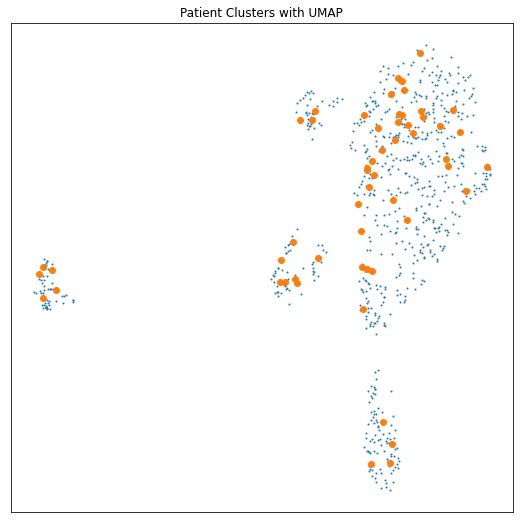

In [65]:
plt.figure(figsize=(9, 9))
plt.xticks([])
plt.yticks([])
plt.title('Patient Clusters with UMAP')
plt.plot(embedding[:, 0], embedding[:, 1], 'o', markersize=1);
plt.plot(embedding[df_label['outcomes_1year'].to_numpy(dtype=bool), 0],
         embedding[df_label['outcomes_1year'].to_numpy(dtype=bool), 1],'o')

# for age indx comment uncomment this

In [66]:
X=df_input_stnd.to_numpy()
y=df_label['outcomes_1year'].to_numpy()

#X=df_input_stnd.loc[indx_age].to_numpy()
#y=df_label.loc[indx_age]['outcomes_1year'].to_numpy()

In [67]:
X.shape

(800, 1098)

In [48]:
y.sum()

29386

In [33]:
"""lr_pipe = Pipeline(steps=[
('scaler', StandardScaler(with_mean=True, with_std=True)),
('lr', LogisticRegression(solver='liblinear', max_iter=5000, random_state=0))
])
"""
lr_pipe = Pipeline(steps=[
('lr', LogisticRegression(solver='liblinear', class_weight='balanced',max_iter=5000, random_state=0))
])

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

scores=cross_val_score(lr_pipe, X, y, cv=5,
                       scoring=make_scorer(classification_report_with_accuracy_score))
print(scores)
print(classification_report(originalclass, predictedclass))

[0.68319818 0.68300357 0.68226835 0.68197643 0.68605996]
              precision    recall  f1-score   support

           0       0.96      0.68      0.80    423273
           1       0.16      0.67      0.26     39176

    accuracy                           0.68    462449
   macro avg       0.56      0.68      0.53    462449
weighted avg       0.89      0.68      0.75    462449



In [135]:
# Run classifier with cross-validation and plot ROC curves
def plot_aucpr_aucroc_cv(classifier,X,y,cv,callback_list=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=1000
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[0])

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz.fpr,viz.tpr))

        viz2 = plot_precision_recall_curve(classifier, X[test], y[test],
                             name='PRC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[1])
        recall_temp_sorted_ind=np.argsort(viz2.recall)
        recall_temp_sorted=viz2.recall[recall_temp_sorted_ind]
        precision_temp_sorted=viz2.precision[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz2.recall,viz2.precision)
        avg_precisions.append(viz2.average_precision)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y[test],classifier.predict_proba(X[test])[:,1],n_bins=num_cal_bins,strategy='quantile')
        
            
        
        if isinstance(classifier, XGBClassifier):
            feature_importance.append(classifier.feature_importances_)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")


    plt.show()
    
    return feature_importance

In [34]:
# Run classifier with cross-validation and plot ROC curves
def plot_aucpr_aucroc_bs_test_hp(classifierC,X_test,y_test,cv):
    #plot aupr_auroc with bootstraping of the test set to draw uncertainty
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=100
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    classifier=classifierC
    
    rs=cv
    #This randmely samples the test set and and draws graphs/metric for each set
    for i,(sample,_) in enumerate(rs.split(X_test)):        
        viz = plot_roc_curve(classifier.best_estimator_, X_test[sample], y_test[sample],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[0])

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz.fpr,viz.tpr))

        viz2 = plot_precision_recall_curve(classifier.best_estimator_,  X_test[sample], y_test[sample],
                             name='PRC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[1])
        recall_temp_sorted_ind=np.argsort(viz2.recall)
        recall_temp_sorted=viz2.recall[recall_temp_sorted_ind]
        precision_temp_sorted=viz2.precision[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz2.recall,viz2.precision)
        avg_precisions.append(viz2.average_precision)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y_test[sample],classifier.best_estimator_.predict_proba(X_test[sample])[:,1],n_bins=num_cal_bins,strategy='quantile')
        
            
        
        if isinstance(classifier, XGBClassifier):
            feature_importance.append(classifier.feature_importances_)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")


    plt.show()
    
    return {"classifier":classifier,"feature_importance":feature_importance}






  0%|          | 0/5 [00:00<?, ?it/s]




 20%|██        | 1/5 [00:01<00:06,  1.62s/it]




Fold #0::  20%|██        | 1/5 [00:01<00:06,  1.62s/it]

you got it right







Fold #0::  40%|████      | 2/5 [00:04<00:05,  1.87s/it]




Fold #1::  40%|████      | 2/5 [00:04<00:05,  1.87s/it]

you got it right







Fold #1::  60%|██████    | 3/5 [00:06<00:03,  1.98s/it]




Fold #2::  60%|██████    | 3/5 [00:06<00:03,  1.98s/it]

you got it right







Fold #2::  80%|████████  | 4/5 [00:08<00:02,  2.10s/it]




Fold #3::  80%|████████  | 4/5 [00:08<00:02,  2.10s/it]

you got it right







Fold #3:: 100%|██████████| 5/5 [00:11<00:00,  2.46s/it]




Fold #4:: 100%|██████████| 5/5 [00:11<00:00,  2.46s/it]

you got it right
[[0.09210526 0.05263158 0.07236842 0.07236842 0.05960265 0.06578947
  0.05921053 0.03289474 0.05263158 0.08609272 0.09210526 0.07236842
  0.06578947 0.10526316 0.1192053  0.06578947 0.06578947 0.05263158
  0.09868421 0.0794702  0.08552632 0.11842105 0.13815789 0.12582781
  0.07236842 0.10526316 0.08552632 0.11842105 0.0794702  0.07236842
  0.09868421 0.07894737 0.11184211 0.06622517 0.07894737 0.11842105
  0.08552632 0.08552632 0.10596026 0.07894737 0.13815789 0.13815789
  0.11258278 0.10526316 0.10526316 0.16447368 0.13157895 0.14569536
  0.17763158 0.13815789 0.15131579 0.17105263 0.13245033 0.11184211
  0.14473684 0.15789474 0.15789474 0.19205298 0.15131579 0.11184211
  0.18421053 0.18543046 0.14473684 0.20394737 0.14473684 0.17763158
  0.20529801 0.15789474 0.15131579 0.21710526 0.16447368 0.1986755
  0.17763158 0.19736842 0.17763158 0.21710526 0.23178808 0.22368421
  0.11842105 0.23684211 0.21854305 0.22368421 0.20394737 0.11842105
  0.21052632 0.21192053 0.197368

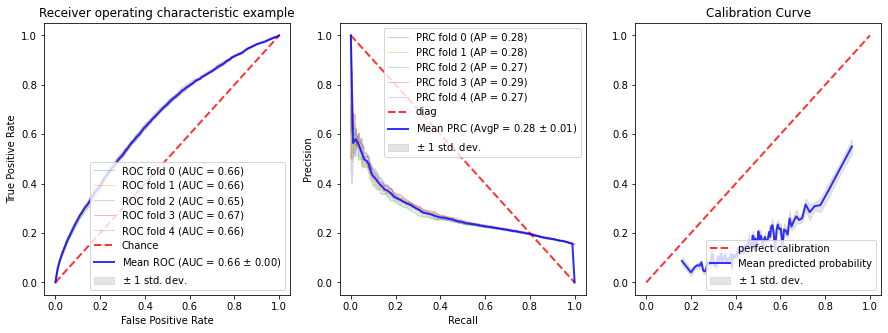

Time elapsed: 291.2250347714871


In [110]:
train_d, test_d, train_label_d, test_label_d = train_test_split(X,y, test_size=0.3)
#train_d, val_d, train_label_d, val_label_d = train_test_split(train_d,train_label_d, test_size=0.2)

tic = time.perf_counter()

#classifier = svm.SVC(kernel='linear', probability=True,random_state=0)
classifierC= LogisticRegression(solver='liblinear',penalty='l1', max_iter=100,tol=0.001, random_state=0,class_weight='balanced')#solver='liblinear',penalty='l1',C=0.01, max_iter=1000,tol=0.01, random_state=0,class_weight='balanced'
fit_params={"sample_weight":None}
hp_params=dict(C=scipy.stats.uniform(loc=0,scale=1))

classifier=RandomizedSearchCV(
    classifierC,
    hp_params,
    n_iter=3,
    scoring='average_precision',
    random_state=0,
    cv=5,
    verbose=0,
)


#classifier= CalibratedClassifierCV(base_estimator=classifier1, cv=3)
classifierF=classifier.fit(train_d,train_label_d,**fit_params)

rs = ShuffleSplit(n_splits=5,test_size=.5)

#fit params is for Early stopping
results_dict=plot_aucpr_aucroc_bs_test_hp(classifierF,test_d,test_label_d,rs)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

In [204]:
# Run classifier with cross-validation and plot ROC curves
def plot_aucpr_aucroc_ncv_hp(classifierC,X,y,cv,hp_params_dict,callback_list=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    #calibration curve
    num_cal_bins=100
    prob_true=np.zeros([cv.n_splits,num_cal_bins]) 
    prob_pred=np.zeros([cv.n_splits,num_cal_bins]) 
    
    feature_importance=[]


    fig, ax = plt.subplots(1,3,figsize=[15,5])
    
    
    
    pbar = tqdm(total=5)
    
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        #for this I'm replacing fit with BayeSearchCV for nested CV hyperparameter tuning
        classifier=RandomizedSearchCV(
            classifierC,
            hp_params_dict,
            n_iter=10,
            scoring='average_precision',
            random_state=0
        )
        
        classifier=classifier.fit(X[train], y[train])
        print('best parameters: ',classifier.best_params_)
        
        
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[0])

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz.fpr,viz.tpr))

        viz2 = plot_precision_recall_curve(classifier, X[test], y[test],
                             name='PRC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax[1])
        recall_temp_sorted_ind=np.argsort(viz2.recall)
        recall_temp_sorted=viz2.recall[recall_temp_sorted_ind]
        precision_temp_sorted=viz2.precision[recall_temp_sorted_ind]
        interp_precision = np.interp(mean_recall,recall_temp_sorted,precision_temp_sorted)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz2.recall,viz2.precision)
        avg_precisions.append(viz2.average_precision)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
        print('you got it right')
        
        #calibration curve
        
        prob_true[i,:], prob_pred[i,:]=calibration_curve(y[test],classifier.predict_proba(X[test])[:,1],n_bins=num_cal_bins,strategy='quantile')
        
            
        
        if isinstance(classifier, XGBClassifier):
            feature_importance.append(classifier.feature_importances_)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='diag', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(avg_precisions)#np.std(aucs_pr)
    ax[1].plot( mean_recall,mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")
    
    
    #Calibration curve
    ax[2].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='perfect calibration', alpha=.8)
    mean_prob_true = np.mean(prob_true, axis=0)
    mean_prob_pred = np.mean(prob_pred, axis=0)
    print(prob_true),print(prob_pred)
    
    std_prob_true=np.std(prob_true, axis=0)

    ax[2].plot(mean_prob_pred, mean_prob_true, color='b',
            label='Mean predicted probability',
            lw=2, alpha=.8)

    prob_true_upper = np.minimum(mean_prob_true + std_prob_true, 1)
    prob_true_lower = np.maximum(mean_prob_true - std_prob_true, 0)
    ax[2].fill_between(mean_prob_pred, prob_true_lower, prob_true_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Calibration Curve")
    ax[2].legend(loc="lower right")


    plt.show()
    
    return feature_importance

In [205]:
import scipy.stats

In [ ]:
tic = time.perf_counter()


#classifier = svm.SVC(kernel='linear', probability=True,random_state=0)
classifier= LogisticRegression(solver='saga',penalty='l1', max_iter=100,tol=0.01, random_state=0,class_weight='balanced')#solver='liblinear',penalty='l1',C=0.01, max_iter=1000,tol=0.01, random_state=0,class_weight='balanced'
hp_params=dict(C=scipy.stats.uniform(loc=0,scale=1))
#classifier= CalibratedClassifierCV(base_estimator=classifier1, cv=3)
cv = StratifiedKFold(n_splits=5)
plot_aucpr_aucroc_ncv_hp(classifier,X,y,cv,hp_params)
toc = time.perf_counter()

print('Time elapsed: '+str(toc-tic))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …















  0%|                                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]

best parameters:  {'C': 0.9636627605010293}
















 20%|███████████████████████████████████████▍                                                                                                                                                             | 1/5 [3:14:36<12:58:26, 11676.61s/it]













Fold #0::  20%|█████████████████████████████████████▍                                                                                                                                                     | 1/5 [3:14:36<12:58:26, 11676.61s/it]

you got it right
best parameters:  {'C': 0.9636627605010293}
















Fold #0::  40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                | 2/5 [6:24:11<9:34:56, 11498.97s/it]













Fold #1::  40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                | 2/5 [6:24:11<9:34:56, 11498.97s/it]

you got it right


In [ ]:
tic = time.perf_counter()
neg_class, pos_class = np.bincount(y.astype(int))
classifier= XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=1000,scale_pos_weight=neg_class/pos_class)
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc_cv(classifier,X,y,cv)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

In [ ]:
fig,ax=plt.subplots(figsize=(30,15))
mean_feature_importance=np.mean(feature_importance,axis=0)
std_feature_importance=np.std(feature_importance,axis=0)
sorted_idx=np.argsort(mean_feature_importance)

plt.barh(df_input.columns.values[sorted_idx][-50:]
         mean_feature_importance[sorted_idx][-50:],
         xerr=std_feature_importance[sorted_idx][-50:])
fig.savefig('features')

In [ ]:
df_input.columns.values[sorted_idx][-20:]

In [ ]:
tic = time.perf_counter()
neg_class, pos_class = np.bincount(y.astype(int))

classifier= XGBClassifier(scale_pos_weight=neg_class/pos_class,eval_metric='logloss',use_label_encoder =False)


hp_params=dict(
              min_child_weight=[5,10,20,50],
              gamma=[0.5,1,1.5,2,5,10],
              max_depth=[5,6,7,8,9,10],
              subsample= [0.6, 0.8, 1.0],
               colsample_bytree=[0.6, 0.8, 1.0],
               learning_rate=[0.005,0.01,0.02,0.05,0.1],
               n_estimators=[200,400,600,800,1000]
              )
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc_ncv_hp(classifier,X,y,cv,hp_params)
toc = time.perf_counter()
print('Time elapsed: '+str(toc-tic))

# DNN

In [34]:
train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["MI_60"], test_size=0.2)

In [35]:
test_label_df.shape

(8314,)

In [35]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Positives: ', np.sum(cm[1]))


logs/csvLogs
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping


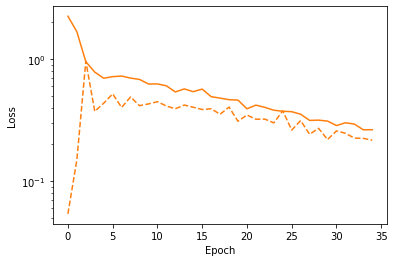

In [36]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, input_shape=None, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.Input(shape=(input_shape,)),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(60, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

def make_dir_for_callback_obj(callback_list):
    for callbackobj in callback_list:
        if  isinstance(callbackobj,tf.keras.callbacks.CSVLogger):
            dir_path=''
            for sub_dir in callbackobj.filename.split('/')[:-1]:
                dir_path=os.path.join(dir_path,sub_dir)
            print(dir_path)
                

            csv_file_name=callbackobj.filename.split('/')[-1]
            try:
                os.makedirs(dir_path)
            except FileExistsError:
                pass
                
    return


# split and shuffle 
train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["MI_60"], test_size=0.2)
train_df, val_df, train_label_df, val_label_df = train_test_split(train_df,train_label_df, test_size=0.2)

train=np.array(train_df)
val=np.array(val_df)
train_label=np.array(train_label_df)
val_label=np.array(val_label_df)
test=np.array(test_df)
test_label=np.array(test_label_df)





EPOCHS = 100
BATCH_SIZE = 2000


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



neg, pos = np.bincount(df_label["MI_60"])
weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model = make_model(output_bias=np.log([pos/neg]),input_shape=train.shape[-1])


MODEL_NAME='FFDNN'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]

make_dir_for_callback_obj(callback_list)

model=model.fit(
    train,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_list,
    validation_data=(val, val_label),
    verbose=0,
    class_weight=class_weight)
plot_loss(model, "Careful Bias", 1)

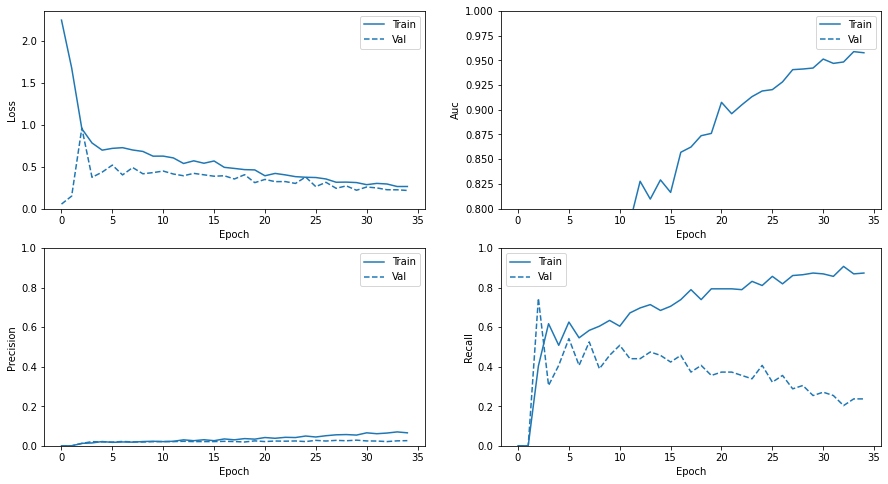

In [37]:
plt.subplots(figsize=(15,8))
plot_metrics(model)

5/5 [==============================] - 0s 6ms/step - loss: 0.3939 - tp: 36.0000 - fp: 1481.0000 - tn: 6764.0000 - fn: 33.0000 - accuracy: 0.8179 - precision: 0.0237 - recall: 0.5217 - auc: 0.7522
loss :  0.3938952386379242
tp :  36.0
fp :  1481.0
tn :  6764.0
fn :  33.0
accuracy :  0.8178974986076355
precision :  0.02373104728758335
recall :  0.52173912525177
auc :  0.7521721124649048

True Negatives:  6764
False Positives:  1481
False Negatives:  33
True Positives:  36
Total Positives:  69


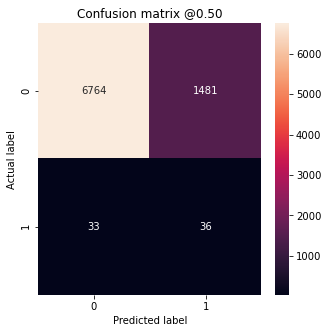

In [38]:

results = model.model.evaluate(test,test_label, batch_size=BATCH_SIZE )
for name, value in zip(model.model.metrics_names,results):
  print(name, ': ', value)
print()

plot_cm(test_label, model.model.predict(test,batch_size=BATCH_SIZE),0.5)


In [62]:
model.history

{'loss': [1.8226218223571777,
  1.0791374444961548,
  1.0211671590805054,
  0.9513974785804749,
  0.9565366506576538,
  0.9456659555435181,
  0.909311830997467,
  0.8278852105140686,
  0.864255428314209,
  0.8086473941802979,
  0.8390923142433167,
  0.794999361038208,
  0.7723305821418762,
  0.7374873161315918,
  0.7405140399932861,
  0.7901685237884521,
  0.7037026882171631,
  0.743937075138092,
  0.70658940076828,
  0.6813036799430847,
  0.7035400867462158,
  0.7118718028068542,
  0.6521552801132202,
  0.6588566899299622,
  0.6353256106376648,
  0.6812369227409363,
  0.6555902361869812,
  0.594567596912384,
  0.6127669811248779,
  0.6441634893417358,
  0.6119324564933777,
  0.6568459868431091,
  0.5930598974227905,
  0.5992714166641235,
  0.6251961588859558,
  0.5924609303474426,
  0.5927090644836426,
  0.5707353353500366,
  0.560417115688324,
  0.5540512800216675,
  0.609468400478363,
  0.5593307614326477,
  0.5671233534812927,
  0.5668725371360779,
  0.5839013457298279,
  0.5539949

<ipython-input-41-a02aad051412>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=5)


Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


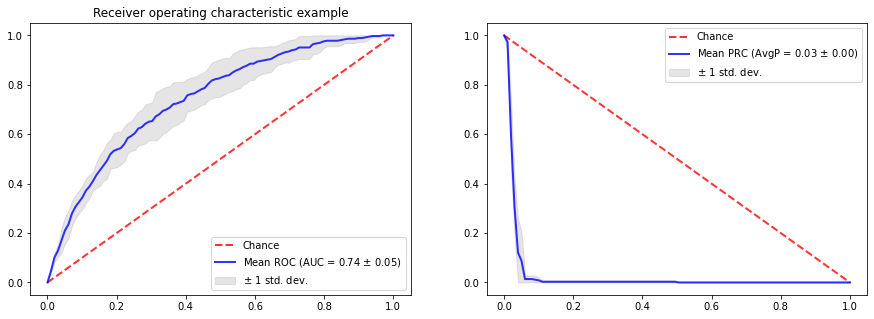

In [42]:
tic = time.perf_counter()


callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)
              ]



model = make_model(output_bias=np.log([pos/neg]),input_shape=train.shape[-1])
classifier= model
classifier.save_weights('model_DNN_initial_weights.h5')
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc_cv(classifier,X,y,cv,callback_list)
toc = time.perf_counter()

In [885]:
def make_model_hp(hp, metrics=METRICS, input_shape=None, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(train_df.shape[1],)))    
    for i in range(hp.Int('num_layers',2,5)):
        model.add(keras.layers.Dense(hp.Int('units_'+str(i), 
                                        min_value = 32, 
                                        max_value = 256, 
                                        step = 32,
                                        default=32),
                                 activation='relu'))
        model.add(keras.layers.Dropout(hp.Float('dropout_'+str(i),
                    min_value=0.0,
                    max_value=0.4,
                    default=0.01,
                    step=0.01)))
    

    model.add(keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model




class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project my_dir/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/untitled_project/tuner0.json


In [1191]:
MODEL_NAME='hyper_DNN'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]


make_dir_for_callback_obj(callback_list)

tuner=kt.tuners.bayesian.BayesianOptimization(make_model_hp,
                     objective = kt.Objective("val_auc", direction="max"), 
                     max_trials=10,
                     seed = 42,
                     executions_per_trial=3,
                     directory = 'logs/kt')

tuner.search(train, train_label, epochs = 50, 
             validation_data = (val_df, val_label_df), 
             callbacks = callback_list,
            verbose=0)


IndentationError: unexpected indent (<ipython-input-1191-325e9fd6deed>, line 33)

In [1175]:
tuner.results_summary()

Results summary
Results in logs/kt/untitled_project
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 32
dropout_0: 0.2
units_1: 96
dropout_1: 0.39
learning_rate: 0.0001
units_2: 224
dropout_2: 0.04
units_3: 256
dropout_3: 0.02
Score: 0.7381932735443115
Trial summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout_0: 0.36
units_1: 96
dropout_1: 0.11
learning_rate: 0.0001
units_2: 128
dropout_2: 0.31
units_3: 32
dropout_3: 0.2
Score: 0.7365760405858358
Trial summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout_0: 0.2
units_1: 96
dropout_1: 0.33
learning_rate: 0.0001
units_2: 160
dropout_2: 0.15
units_3: 96
dropout_3: 0.14
Score: 0.7356385389963785
Trial summary
Hyperparameters:
num_layers: 4
units_0: 128
dropout_0: 0.02
units_1: 32
dropout_1: 0.2
learning_rate: 0.0001
units_2: 64
dropout_2: 0.18
units_3: 32
dropout_3: 0.29
Score: 0.7315447926521301
Trial summary
Hyperparameters:
num_layers: 3
units_0: 160
dro

<ipython-input-501-ccc298c782d9>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=5)


Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping


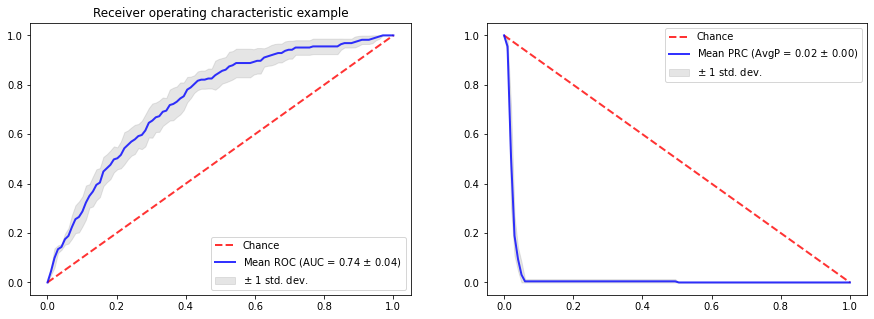

In [1176]:
tic = time.perf_counter()
classifier= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
classifier.save_weights('model_DNN_initial_weights.h5')
classifier.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc(classifier,train, train_label,cv)
toc = time.perf_counter()

In [1177]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                16128     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                3168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 224)               21728     
_________________________________________________________________
dropout_2 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               5

# DNN-EMB 

In [66]:
train_df.head()

,50-0.0,21001-0.0,SBP_avg,DBP_avg,PR_avg,Alcohol Status_Current,Alcohol Status_Never,Alcohol Status_Prefer not to answer,Alcohol Status_Previous,Smoking Status_Current,Smoking Status_Never,Smoking Status_Prefer not to answer,Smoking Status_Previous,189-0.0,21022-0.0,31-0.0,Ethnicity_African,Ethnicity_Any other Asian background,Ethnicity_Any other Black background,Ethnicity_Any other mixed background,Ethnicity_Any other white background,Ethnicity_Asian or Asian British,Ethnicity_Bangladeshi,Ethnicity_Black or Black British,Ethnicity_British,Ethnicity_Caribbean,Ethnicity_Chinese,Ethnicity_Do not know,Ethnicity_Indian,Ethnicity_Irish,Ethnicity_Mixed,Ethnicity_Other ethnic group,Ethnicity_Pakistani,Ethnicity_Prefer not to answer,Ethnicity_White,Ethnicity_White and Asian,Ethnicity_White and Black African,Ethnicity_White and Black Caribbean,"Household_inc_18,000 to 30,999","Household_inc_31,000 to 51,999","Household_inc_52,000 to 100,000",Household_inc_Do not know,"Household_inc_Greater than 100,000","Household_inc_Less than 18,000",Household_inc_Prefer not to answer,Employment_Doing unpaid or voluntary work,Employment_Full or part-time student,Employment_In paid employment or self-employed,Employment_Looking after home and/or family,Employment_None of the above,...,thyroid radioablation therapy,thyroiditis,tinnitus / tiniitis,tonsiltis,transient ischaemic attack (tia),trapped nerve/compressed nerve,trigemminal neuralgia,tuberculosis (tb),type 1 diabetes,type 2 diabetes,typhoid fever,ulcerative colitis,umbilical hernia,undescended testicle,ureteric obstruction/hydronephrosis,urinary frequency / incontinence,urinary tract infection/kidney infection,urticaria,uterine fibroids,uterine polyps,uterine problem,vaginal prolapse/uterine prolapse,varicella zoster virus,varicose ulcer,varicose veins,vasculitis,venous thromboembolic disease,vertigo,vitiligo,vocal cord polyp,wegners granulmatosis,whooping cough / pertussis,wolff parkinson white / wpw syndrome,yellow fever,Home_Longitude,Home_Latitude,20118-0.0,24007-0.0,24005-0.0,24004-0.0,24008-0.0,24006-0.0,24003-0.0,24010-0.0,24014-0.0,24013-0.0,24009-0.0,24012-0.0,24011-0.0,24015-0.0
36438,0.405811,-0.638041,-1.237288,-1.071657,54,1,0,0,0,0,0,0,1,-0.823127,-1.201193,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.483396,-0.040937,-0.391844,-0.570542,-0.193689,-0.028710,-0.728625,0.500507,-0.032028,-0.280023,0,-0.336985,-0.203008,-0.082362,-0.454158,-0.359943
7842,0.836789,-0.047154,-0.345525,-0.659812,72,1,0,0,0,0,0,0,1,0.325762,0.171296,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.453543,1.094590,-0.391844,0.248094,0.367221,0.345404,0.002402,1.019848,0.423257,-0.556114,0,2.096601,2.940863,0.262641,-0.377949,1.843365
20724,0.082577,-0.807979,-1.070082,-1.174618,66,1,0,0,0,0,1,0,0,-1.026084,0.420840,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.587883,-0.040937,-0.391844,0.481990,0.389435,0.279539,0.234473,0.130975,0.280475,0.272160,0,-0.336985,-0.203008,-0.118517,0.690669,-0.359943
24413,1.375513,0.296147,-0.122585,0.575721,60,1,0,0,0,0,1,0,0,-1.057003,-1.201193,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.442153,-1.085622,-0.391844,0.014198,-0.177029,0.242654,-0.693814,0.200887,0.260270,-0.418069,0,-0.336985,-0.203008,-0.067655,-0.014825,-0.359943
30651,2.237470,-0.204950,-0.568466,0.266838,84,1,0,0,0,0,0,0,1,-1.044061,-0.951650,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.453543,1.075124,-0.391844,-0.570542,-0.188136,0.219601,-0.670607,0.280786,0.048792,-0.591178,0,-0.336985,-0.203008,-0.302355,-0.215557,-

In [67]:
selected_categories_tidy_columns

{'gender': {'col_name': ['31-0.0'], 'type': 'binary'},
 'birth_date': {'col_name': ['birth_date'], 'type': 'date'},
 'Townsend deprivation index at recruitment': {'col_name': ['189-0.0'],
  'type': 'float'},
 'Age at recruitment': {'col_name': ['21022-0.0'], 'type': 'int'},
 'Ethnicity': {'col_name': ['Ethnicity_African',
   'Ethnicity_Any other Asian background',
   'Ethnicity_Any other Black background',
   'Ethnicity_Any other mixed background',
   'Ethnicity_Any other white background',
   'Ethnicity_Asian or Asian British',
   'Ethnicity_Bangladeshi',
   'Ethnicity_Black or Black British',
   'Ethnicity_British',
   'Ethnicity_Caribbean',
   'Ethnicity_Chinese',
   'Ethnicity_Do not know',
   'Ethnicity_Indian',
   'Ethnicity_Irish',
   'Ethnicity_Mixed',
   'Ethnicity_Other ethnic group',
   'Ethnicity_Pakistani',
   'Ethnicity_Prefer not to answer',
   'Ethnicity_White',
   'Ethnicity_White and Asian',
   'Ethnicity_White and Black African',
   'Ethnicity_White and Black Caribbe

In [68]:
"""
# split and shuffle 
train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["MI_60"], test_size=0.2)
train_df, val_df, train_label_df, val_label_df = train_test_split(train_df,train_label_df, test_size=0.2)
"""

selected_categories_tidy_columns_cat={k:v for k,v in selected_categories_tidy_columns.items() 
                                      if v['type']=='binary' and len(v["col_name"])>2}

word_index_dict={}
index=0
for k,v in selected_categories_tidy_columns_cat.items():
    for col in v['col_name']:
        word_index_dict[col]=index
        index+=1

cols_for_sentences=[k for k,v in word_index_dict.items()]
patient_sentences=[]
patient_sentences_val=[]
df_to_token=train_df[cols_for_sentences]


token = tf.keras.preprocessing.text.Tokenizer(num_words=len(word_index_dict))
token.word_index=word_index_dict

#Convert row to padded 
def word_to_indx(word):
    return word_index_dict[word]
    
df_to_token=df_input_stnd[cols_for_sentences]
for index in df_to_token.index:
    patient_sentences.append(list(map(word_to_indx,df_to_token.loc[index,df_to_token.loc[index]==1].index.values)))

    
data_cat=tf.keras.preprocessing.sequence.pad_sequences(sequences=patient_sentences,dtype='int32', padding='pre')
data_num=np.array(df_input_stnd[train_df.columns.difference(cols_for_sentences)]) 

data_cat_cols=data_cat.shape[1]
data_num_cols=data_num.shape[1]

data_all=np.concatenate((data_cat,data_num),axis=1)

train, test, train_label, test_label = train_test_split(data_all,np.array(df_label["MI_60"]), test_size=0.2)
train, val, train_label, val_label = train_test_split(train,train_label, test_size=0.2)

In [69]:
train.shape

(26601, 48)

In [1349]:
output_bias=np.log([pos/neg])

def make_model_EMD_hp(hp, metrics=METRICS, input_shape=None, output_bias=None,clone_from=None,word_index_dict=word_index_dict,input_data=[train_cat,train_num]):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    no_of_unique_cat  = len(word_index_dict)

    embedding_size = hp.Int('embedding_size', 
                                        min_value = 20, 
                                        max_value = 50, 
                                        step = 10,
                                        default=50)

    inp_cat_data = keras.layers.Input(shape=(train_cat.shape[1],))
    emb = keras.layers.Embedding(input_dim=no_of_unique_cat, output_dim=embedding_size,input_shape=(None,train_cat.shape[1]))(inp_cat_data) 
    flatten = keras.layers.Flatten()(emb)

    inp_num_data = keras.layers.Input(shape=(train_num.shape[1],))

    conc = keras.layers.Concatenate()([flatten, inp_num_data])   

    current=conc
    for i in range(hp.Int('num_layers',2,5)):
        new=keras.layers.Dense(hp.Int('units_'+str(i), 
                                            min_value = 32, 
                                            max_value = 256, 
                                            step = 32,
                                            default=32),activation='relu')(current)

        new=keras.layers.Dropout(hp.Float('dropout_'+str(i),
                    min_value=0.0,
                    max_value=0.4,
                    default=0.05,
                    step=0.05))(new)
        current=new

    out=keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(new)

    hp_learning_rate =hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])


    model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    return model

In [1350]:
MODEL_NAME='hyper_DNN_EMB'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]


make_dir_for_callback_obj(callback_list)



train_cat=train[:,:data_cat_cols] #train_cat
train_num=train[:,data_cat_cols:]#train_num
val_cat=val[:,:data_cat_cols] 
val_num=val[:,data_cat_cols:]


tuner = kt.tuners.bayesian.BayesianOptimization(
    make_model_EMD_hp,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    executions_per_trial=3,
    project_name=MODEL_NAME,
    directory=os.path.join(log_dir,'kt',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))))


tuner.search([train_cat,train_num], train_label, epochs = 50, 
             validation_data = ([val_cat,val_num], val_label), 
             callbacks = callback_list,
            verbose=1,
             batch_size=5*BATCH_SIZE)

Trial 10 Complete [00h 01m 08s]
val_auc: 0.7078262368837992

Best val_auc So Far: 0.7078262368837992
Total elapsed time: 00h 11m 54s
INFO:tensorflow:Oracle triggered exit


In [1347]:
tuner.get_best_models(1)[0].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 50)       23900       input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1150)         0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

In [1351]:
tuner.results_summary()

Results summary
Results in logs/kt/hyper_DNN_EMB_21_02_12_11_01/hyper_DNN_EMB
Showing 10 best trials
Objective(name='val_auc', direction='max')
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 3
units_0: 128
dropout_0: 0.0
units_1: 64
dropout_1: 0.0
learning_rate: 0.01
units_2: 192
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
units_4: 192
dropout_4: 0.15000000000000002
Score: 0.7078262368837992
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 5
units_0: 224
dropout_0: 0.0
units_1: 128
dropout_1: 0.0
learning_rate: 0.01
units_2: 64
dropout_2: 0.0
units_3: 256
dropout_3: 0.0
units_4: 32
dropout_4: 0.05
Score: 0.6985142628351847
Trial summary
Hyperparameters:
embedding_size: 40
num_layers: 3
units_0: 128
dropout_0: 0.1
units_1: 192
dropout_1: 0.15000000000000002
learning_rate: 0.001
units_2: 160
dropout_2: 0.05
units_3: 192
dropout_3: 0.0
Score: 0.691669245560964
Trial summary
Hyperparameters:
embedding_size: 50
num_layers: 3
units_0: 160
dropout_0: 0.05
units_1: 3

In [1352]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 50)       23900       input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1150)         0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

In [1357]:
tuner.get_best_hyperparameters(1)[0].get_config()['values']['learning_rate']

0.01

In [1391]:
def plot_aucpr_aucroc_cv_mixedX(classifier,X,y,cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    precisions = []
    avg_precisions = []
    aucs_pr=[]
    mean_recall = np.linspace(0, 1, 100)
    
    feature_importance=[]


    fig, ax = plt.subplots(1,2,figsize=[15,5])
    
    
    
    pbar = tqdm_notebook(total=5)
    
    num_cols_cat=X[0].shape[1]
    X=np.concatenate(X,axis=1)
    
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.load_weights('model_DNN_initial_weights.h5')

        X_train,X_val, y_train,y_val=train_test_split(X[train], y[train],test_size=0.2, random_state=0)
        classifier.fit([X_train[:,:num_cols_cat],X_train[:,num_cols_cat:]], y_train, batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       callbacks=callback_list,
                       validation_data=([X_val[:,:num_cols_cat],X_val[:,num_cols_cat:]], y_val), 
                       verbose=0,
                       class_weight=class_weight)
        viz_fpr, viz_tpr, thresholds=roc_curve(y[test],
                                               classifier.predict([X[test][:,:num_cols_cat],
                                                                   X[test][:,num_cols_cat:]]).ravel())
        interp_tpr = np.interp(mean_fpr, viz_fpr, viz_tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(viz_fpr,viz_tpr))

        viz_precision,viz_recall,thresholds=precision_recall_curve(y[test],
                                                                   classifier.predict([X[test][:,:num_cols_cat],
                                                                   X[test][:,num_cols_cat:]]).ravel())
        interp_precision = np.interp(mean_recall,viz_precision,viz_recall)
        interp_precision[0] = 1
        precisions.append(interp_precision)
        aucs_pr=auc(viz_recall,viz_precision)
        avg_precisions.append(aucs_pr)

        pbar.update(1)
        pbar.set_description('Fold #{}:'.format(i), refresh=True)
            

    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax[0].legend(loc="lower right")


    ax[1].plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[-1] = 0
    mean_aucpr = auc(mean_recall, mean_precision)
    std_aucpr = np.std(aucs_pr)
    ax[1].plot(mean_recall, mean_precision, color='b',
            label=r'Mean PRC (AvgP = %0.2f $\pm$ %0.2f)' % (mean_aucpr, std_aucpr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax[1].fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax[1].legend(loc="upper right")


    plt.show()
    
    return feature_importance

<ipython-input-1391-10dab1086763>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=5)


Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


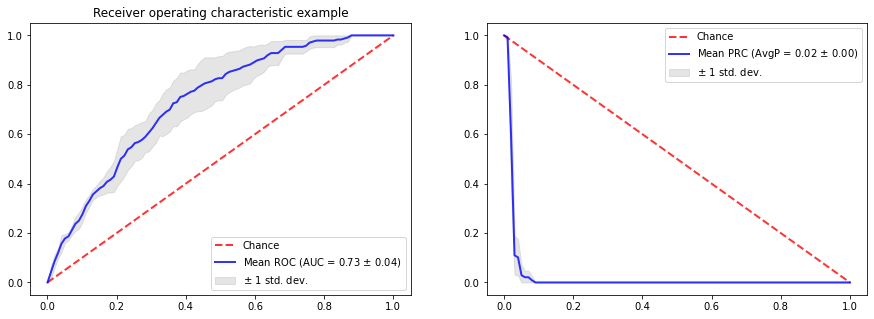

In [1392]:
tic = time.perf_counter()
classifier= tf.keras.models.clone_model(tuner.get_best_models(num_models=1)[0])
classifier.save_weights('model_DNN_initial_weights.h5')
classifier.compile(
    optimizer=keras.optimizers.Adam(lr=
                                    tuner.get_best_hyperparameters(1)[0].get_config()['values']['learning_rate']),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)
cv = StratifiedKFold(n_splits=5)
feature_importance=plot_aucpr_aucroc_cv_mixedX(classifier,[train_cat,train_num], train_label,cv,callback_list)
toc = time.perf_counter()

In [1397]:
MODEL_NAME='hyper_DNN_EMB_final'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_auc',
                mode='max',
                save_best_only=True),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(log_dir,'TensorBoard',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                histogram_freq=1,
                embeddings_freq=1)
              ]


make_dir_for_callback_obj(callback_list)


classifier.fit([train_cat,train_num], train_label, batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               validation_data=([val_cat,val_num], val_label), 
               verbose=1,
               class_weight=class_weight,
               callbacks=callback_list)

logs/csvLogs
Epoch 1/100
14/14 [==============================] - 1s 85ms/step - loss: 0.5629 - tp: 165.0000 - fp: 7747.0000 - tn: 18618.0000 - fn: 71.0000 - accuracy: 0.7061 - precision: 0.0209 - recall: 0.6992 - auc: 0.7825 - val_loss: 0.6828 - val_tp: 46.0000 - val_fp: 3016.0000 - val_tn: 3577.0000 - val_fn: 12.0000 - val_accuracy: 0.5447 - val_precision: 0.0150 - val_recall: 0.7931 - val_auc: 0.7220
Epoch 2/100
14/14 [==============================] - 1s 39ms/step - loss: 0.5054 - tp: 196.0000 - fp: 8169.0000 - tn: 18196.0000 - fn: 40.0000 - accuracy: 0.6914 - precision: 0.0234 - recall: 0.8305 - auc: 0.8331 - val_loss: 0.3978 - val_tp: 27.0000 - val_fp: 1215.0000 - val_tn: 5378.0000 - val_fn: 31.0000 - val_accuracy: 0.8127 - val_precision: 0.0217 - val_recall: 0.4655 - val_auc: 0.6908
Epoch 3/100
14/14 [==============================] - 1s 41ms/step - loss: 0.4587 - tp: 187.0000 - fp: 6076.0000 - tn: 20289.0000 - fn: 49.0000 - accuracy: 0.7697 - precision: 0.0299 - recall: 0.7924 

In [1401]:
log_dir_tb=os.path.join(log_dir,'TensorBoard','hyper_DNN_EMB_final_21_02_12_13_00')
    
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir_tb, 'metadata.tsv'), "w") as f:
  for word,index in word_index_dict.items():
    f.write("{},{}-{}\n".format(index,index,word.split(',')[0]))

# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(classifier.layers[1].get_weights()[0])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir_tb, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir_tb, config)

In [1071]:
%reload_ext tensorboard

In [1402]:
%tensorboard --logdir {log_dir_tb}

Reusing TensorBoard on port 6006 (pid 62995), started 0:00:57 ago. (Use '!kill 62995' to kill it.)

In [1068]:
!kill 57853

In [1031]:
index_word_dict[338]

'other substance abuse/dependency'

In [1030]:
index_word_dict

{0: 'Ethnicity_African',
 1: 'Ethnicity_Any other Asian background',
 2: 'Ethnicity_Any other Black background',
 3: 'Ethnicity_Any other mixed background',
 4: 'Ethnicity_Any other white background',
 5: 'Ethnicity_Asian or Asian British',
 6: 'Ethnicity_Bangladeshi',
 7: 'Ethnicity_Black or Black British',
 8: 'Ethnicity_British',
 9: 'Ethnicity_Caribbean',
 10: 'Ethnicity_Chinese',
 11: 'Ethnicity_Do not know',
 12: 'Ethnicity_Indian',
 13: 'Ethnicity_Irish',
 14: 'Ethnicity_Mixed',
 15: 'Ethnicity_Other ethnic group',
 16: 'Ethnicity_Pakistani',
 17: 'Ethnicity_Prefer not to answer',
 18: 'Ethnicity_White',
 19: 'Ethnicity_White and Asian',
 20: 'Ethnicity_White and Black African',
 21: 'Ethnicity_White and Black Caribbean',
 22: 'Household_inc_18,000 to 30,999',
 23: 'Household_inc_31,000 to 51,999',
 24: 'Household_inc_52,000 to 100,000',
 25: 'Household_inc_Do not know',
 26: 'Household_inc_Greater than 100,000',
 27: 'Household_inc_Less than 18,000',
 28: 'Household_inc_Prefer 

In [942]:
!rm -rf logs

# AE-DNN

In [43]:
# split and shuffle 


train_df, test_df, train_label_df, test_label_df = train_test_split(df_input_stnd,df_label["MI_60"], test_size=0.2)
train_df, val_df, train_label_df, val_label_df = train_test_split(train_df,train_label_df, test_size=0.2)


binary_cols=list(train_df.columns.difference(non_binary_cols))

train_num=np.array(train_df[non_binary_cols])
train_cat=np.array(train_df[binary_cols])
val_num=np.array(val_df[non_binary_cols])
val_cat=np.array(val_df[binary_cols])
train_label=np.array(train_label_df)
val_label=np.array(val_label_df)

test_num=np.array(test_df[non_binary_cols])
test_cat=np.array(test_df[binary_cols])

test_label=np.array(test_label_df)

In [58]:
latent_dim = 32

def make_stacked_autoencoder_hp(hp):
    class Autoencoder(keras.models.Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        latent_dim = hp.Int('latent_dim', 
                                        min_value = 4, 
                                        max_value = 16, 
                                        step = 4,
                                        default=4)
        #latent_dim=3


        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            keras.Input(shape=train_cat.shape[1]),
            keras.layers.Dense(256, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(latent_dim, activation='sigmoid'),
        ])
        self.decoder = tf.keras.Sequential([
            keras.Input(shape=latent_dim),
            keras.layers.Dense(64, activation='sigmoid'),
            keras.layers.Dense(128, activation='sigmoid'),
            keras.layers.Dense(256, activation='sigmoid'),
          keras.layers.Dense(train_cat.shape[1], activation='sigmoid'),
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


    #hp_learning_rate =hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    hp_learning_rate=0.01

    model = Autoencoder(latent_dim)
    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy())


    return model




"""model=make_stacked_autoencoder_hp()



model.fit(train_cat, train_cat,
                epochs=10,
                shuffle=True,
                validation_data=(val_cat, val_cat))

print(model.summary())"""

'model=make_stacked_autoencoder_hp()\n\n\n\nmodel.fit(train_cat, train_cat,\n                epochs=10,\n                shuffle=True,\n                validation_data=(val_cat, val_cat))\n\nprint(model.summary())'

In [59]:
MODEL_NAME='hyper_DNN_SAE'

log_dir='logs'

callback_list=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True),
           tf.keras.callbacks.CSVLogger(
               os.path.join(log_dir,'csvLogs',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M')) + ".csv"),
               separator=",", append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(log_dir,'checkpoint',
                            MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))),
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True),
              ]


make_dir_for_callback_obj(callback_list)




tuner = kt.tuners.bayesian.BayesianOptimization(
    make_stacked_autoencoder_hp,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=10,
    executions_per_trial=3,
    project_name=MODEL_NAME,
    directory=os.path.join(log_dir,'kt',
                                     MODEL_NAME+ "_" + str( datetime.datetime.now().strftime('%y_%m_%d_%H_%M'))))


tuner.search(train_cat, train_cat, epochs = 50, 
             validation_data = (val_cat, val_cat), 
             callbacks = callback_list,
            verbose=1,
             batch_size=5*BATCH_SIZE)

Trial 10 Complete [00h 00m 18s]
val_loss: 34.264397939046226

Best val_loss So Far: 34.083875020345054
Total elapsed time: 00h 03m 11s
INFO:tensorflow:Oracle triggered exit


In [60]:
tuner.results_summary()

Results summary
Results in logs/kt/hyper_DNN_SAE_21_02_25_23_02/hyper_DNN_SAE
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
latent_dim: 12
Score: 34.083875020345054
Trial summary
Hyperparameters:
latent_dim: 8
Score: 34.264397939046226
Trial summary
Hyperparameters:
latent_dim: 8
Score: 34.30548858642578
Trial summary
Hyperparameters:
latent_dim: 4
Score: 34.387674967447914
Trial summary
Hyperparameters:
latent_dim: 16
Score: 34.441183725992836
Trial summary
Hyperparameters:
latent_dim: 16
Score: 34.63487879435221
Trial summary
Hyperparameters:
latent_dim: 12
Score: 34.63757069905599
Trial summary
Hyperparameters:
latent_dim: 8
Score: 34.679649353027344
Trial summary
Hyperparameters:
latent_dim: 4
Score: 34.72489547729492
Trial summary
Hyperparameters:
latent_dim: 12
Score: 35.112805684407554


In [61]:
model=tuner.get_best_models(num_models=1)[0]


model.fit(train_cat, train_cat,
                epochs=30,
                shuffle=True,
                validation_data=(val_cat, val_cat))


Epoch 1/30
832/832 [==============================] - 3s 3ms/step - loss: 416.8661 - val_loss: 1678.6060
Epoch 2/30
832/832 [==============================] - 2s 3ms/step - loss: 2026.7713 - val_loss: 3360.9651
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 3681.9986 - val_loss: 5078.1484
Epoch 4/30
832/832 [==============================] - 2s 3ms/step - loss: 5370.1390 - val_loss: 6800.0752
Epoch 5/30
832/832 [==============================] - 2s 3ms/step - loss: 7115.5280 - val_loss: 8554.5820
Epoch 6/30
832/832 [==============================] - 2s 3ms/step - loss: 8776.7825 - val_loss: 10299.4824
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 10559.7776 - val_loss: 12080.6328
Epoch 8/30
832/832 [==============================] - 3s 3ms/step - loss: 12214.5917 - val_loss: 13850.0771
Epoch 9/30
832/832 [==============================] - 2s 3ms/step - loss: 13927.9074 - val_loss: 15633.3643
Epoch 10/30
832/832 [===================

In [62]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 12)                165324    
_________________________________________________________________
sequential_1 (Sequential)    (None, 481)               165793    
Total params: 331,117
Trainable params: 331,117
Non-trainable params: 0
_________________________________________________________________


In [130]:
def make_stacked_autoencoder():
    class Autoencoder(keras.models.Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        latent_dim=16


        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            keras.Input(shape=train_cat.shape[1]),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            keras.Input(shape=latent_dim),
            keras.layers.Dense(128, activation='relu'),
          keras.layers.Dense(train_cat.shape[1], activation='sigmoid'),
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


    hp_learning_rate=0.001

    model = Autoencoder(latent_dim)
    model.compile(optimizer=keras.optimizers.Adam(lr=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)
)


    return model

In [131]:
model=make_stacked_autoencoder()

model.fit(train_cat, train_cat,
                epochs=100,
                shuffle=True,
          callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True),],
                validation_data=(val_cat, val_cat))

encoded_records = model.encoder(val_cat).numpy()
decoded_records = model.decoder(encoded_records).numpy()

Epoch 1/100
832/832 [==============================] - 1s 1ms/step - loss: 0.1255 - val_loss: 0.0234
Epoch 2/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0203 - val_loss: 0.0161
Epoch 3/100
832/832 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 4/100
832/832 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 5/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 6/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 7/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0113
Epoch 8/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 9/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 10/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0088 - val_lo

In [132]:
encoded_records = model.encoder(test_cat).numpy()
decoded_records = model.decoder(encoded_records).numpy()

In [133]:
a=800
print(test_cat[a])
print(encoded_records[a])
print((decoded_records[a]>0.5).astype(int))

[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1.6621559 12.838827  1